# BB84 Simplified QKD protocol 

For import we will just need the standard *Qiskit* package with some visualization possibilities and some (classical) package for random numbers generation.

In [1]:
from qiskit import QuantumCircuit
from random import randint
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

Set the number of runs: in generating the key, we will disregard roughly half of the generated outcomes, so for example if you want a key of length $\sim 500$ bits, use $\sim 1000$ runs.

We also pick the simulator and prepare registers for storing outcomes: <code>outA</code> for Alice and <code>outB</code> for Bob (we keep them formally separate in order to show that they are spatially separated).

In [2]:
runs = 10000
simulator = AerSimulator()

outA = []
outB = []

The algorithm is now following.

For each run do the following:
1. Alice chooses randomly the sent bit $x=0$ or $x=1$ and prepares initial state either $|0\rangle$ or $|1\rangle$.
2. Alice chooses randomly whether to leave the bit intact ($a=0$) or whether to change it by Hadamard transformation ($a=1$).
3. Based on her choices she prepared one of the states $\{|0\rangle,|1\rangle,|+\rangle,|-\rangle\}$, which she sends to Bob (over large distance to Galaxy far far away...).
4. Bob receives the sent state and chooses randomly whether to leave it as is ($b=0$) or whether to apply Hadamard transformation on it ($b=1$) without being aware of Alice's choice.
5. Finally Bob performs a measurement and obtains bit $y$.

In [3]:
for i in range(runs):
    x = randint(0, 1)  # Alice's bit
    a = randint(0, 1)  # Alice's choice of transformation
    b = randint(0, 1)  # Bob's choice of transformation
    
    # In each run we create separate circuit corresponding to choices a and b of Alice and Bob
    circuit = QuantumCircuit(1, 1)
    
    # Alice prepares corresponding quantum state to her choice x
    if x:
        circuit.x(0)
    
    # Alice uses Hadamard transformation based on her random choice a
    if a:
        circuit.h(0)
    
    # Alice stores her choices
    outA += [(a, x)]
    
    # Prepared state is sent to Bob
    # Barrier is just a visual aid to show Alice's and Bob's separation
    circuit.barrier()
    
    # Bob uses Hadamard transformation based on his random choice b
    if b: 
        circuit.h(0)
        
    # Finally, bob performs measurement
    circuit.measure(0,0)
    
    # We need only a single output stored in dictionary m
    # from which we extract bit y.
    m = simulator.run(circuit, shots=1).result().get_counts()
    y = (int)(list(m.keys())[0])
    
    # Bob stores his choice and outcome y
    outB += [(b, y)]
    

We can peek at least at the last instance of the circuit.

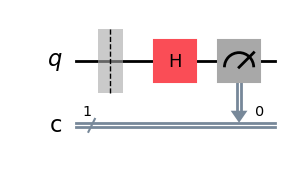

In [4]:
circuit.draw(output="mpl")

Now Alice and Bob by an authenticated channel compare only their choices $a$ and $b$ in respective runs and based on this information keep only those bits $x$ and $y$ for which $a=b$.

In [5]:
# Publicly shared information of ALice and Bob
publicA = [x[0] for x in outA]
publicB = [y[0] for y in outB]

# Locally stored keys obtained from public information
keyA = []
keyB = []

for i in range(runs):
    if publicA[i] == publicB[i]:
        keyA += [outA[i][1]]
        keyB += [outB[i][1]]

Alice and Bob have their separate keys <code>keyA</code> and <code>keyB</code>. Let us check whether these are the same:

In [6]:
keyA == keyB

True

The length of the key is

In [7]:
print(len(keyA))

5022


Let us have a look at the statistic a bit.

In [8]:
counts = {}
out = [(outA[i][0], outB[i][0], outA[i][1], outB[i][1]) for i in range(runs)]
for x in out:
    counts[x] = counts.get(x, 0) + 1

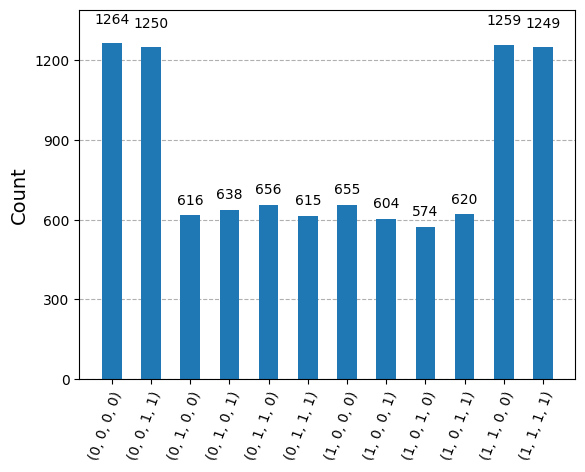

In [9]:
plot_histogram(counts)

The tuples in the chart are ordered $(a,b,x,y)$ and so we see that if $a=b$ (first two columns and last two columns) the obtained bits are also the same, $x=y$, but if $a\neq b$, all possible bit combinations for $x$ and $y$ are (roughly) equally possible.

If we look at the cases where Alice's and Bob's bases coincide, i.e. when $a=b$ we indeed have only correlated keys.

In [10]:
eq_out = {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 0}
for x in counts:
    if x[0] == x[1]:
        eq_out[x[2:]] += counts[x]
print(eq_out)

{(0, 0): 2523, (0, 1): 0, (1, 0): 0, (1, 1): 2499}


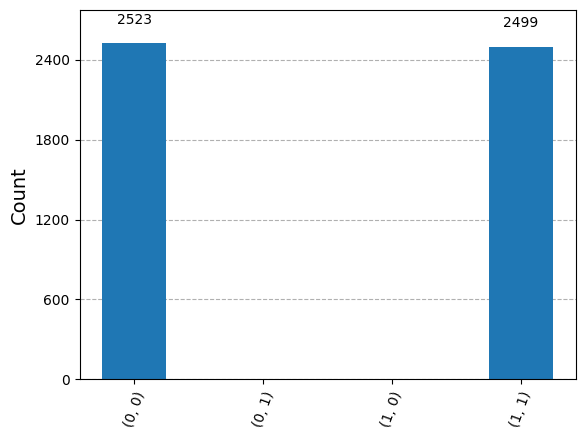

In [11]:
plot_histogram(eq_out)

We see that the procedure provides both Alice and Bob with key that is:
- random (Alice's choices $x$ were random)
- shared between Alice and Bob
- known only to them (we will see later why and how)

## How does it work?

There are eight possibilities of what is happening, which we show in the table below:

| **x** | **a** | **b** | Alice's state | State after Alice changes it | State after Bob changes it | $P(y=\mathbf{0}|x,a,b)$ | $P(y=\mathbf{1}|x,a,b)$ |
|---|---|---|---|---|---|---|---|
| 0 | 0 | 0 | $|0\rangle$ | $|0\rangle$ | $|0\rangle$ | $1/8$ | $0$ |
| 0 | 0 | 1 | $|0\rangle$ | $|0\rangle$ | $|+\rangle$ | $1/16$ | $1/16$ |
| 0 | 1 | 0 | $|0\rangle$ | $|+\rangle$ | $|+\rangle$ | $1/16$ | $1/16$ |
| 0 | 1 | 1 | $|0\rangle$ | $|+\rangle$ | $|0\rangle$ | $1/8$ | $0$ |
| 1 | 0 | 0 | $|1\rangle$ | $|1\rangle$ | $|1\rangle$ | $0$ | $1/8$ |
| 1 | 0 | 1 | $|1\rangle$ | $|1\rangle$ | $|-\rangle$ | $1/16$ | $1/16$ |
| 1 | 1 | 0 | $|1\rangle$ | $|-\rangle$ | $|-\rangle$ | $1/16$ | $1/16$ |
| 1 | 1 | 1 | $|1\rangle$ | $|-\rangle$ | $|1\rangle$ | $0$ | $1/8$ |

We see that if $a=b$ both Alice and Bob apply Hadamard transformation, which effectively does not change the state ($H^2=\mathbb{1}$), and, indeed they have to have $x=y$. If $a\neq b$ we find that the resulting state on Bob's side is $|\pm\rangle$, which, when measured in standard basis gives zeros and ones randomly.

## What about Eve?

If there is an eavesdropper Eve, what she can do is to do the same thing that Bob would do - choose a basis using a bit $e$ and measure. Whatever she measures is also her best guess on what state Alice sent, so she sends it to Bob.

In [12]:
outA = []
outB = []
outE = []

In [13]:
for i in range(runs):
    x = randint(0, 1)  # Alice's bit
    a = randint(0, 1)  # Alice's choice of transformation
    b = randint(0, 1)  # Bob's choice of transformation
    e = randint(0, 1)  # Eve's choice of transformation / measurement
    
    # In each run we create separate circuit corresponding to choices a and b of Alice and Bob
    # Now we have two classical registers, one for Bob's measurement and the second one for Eve's
    circuit = QuantumCircuit(1,2)
    
    # Alice prepares corresponding quantum state to her choice x
    if x:
        circuit.x(0)
    
    # Alice uses Hadamard transformation based on her random choice a
    if a:
        circuit.h(0)
    
    # Alice stores her choices
    outA += [(a,x)]
    
    # Prepared state is sent to Bob but first intercepted by Eve
    # Barrier is just a visual aid to show Alice's and Bob's separation
    circuit.barrier()
    
    # Eve uses Hadamard transformation based on her random choice e
    if e:
        circuit.h(0)
    
    # Then Eve measures to see the outcome
    circuit.measure(0,1)
    
    # After Eve's measurement, the state becomes |0> or |1> based on what she measured
    # This is also Eve's best guess on what the state could be
    # Therefore she prepares it for Bob:
    #    - if e == 0, she does not change it, as it already is |0> or |1>
    #    - if e == 1, she changes it to |+>, |-> basis
    if e:
        circuit.h(0)

    # The state is now sent to Bob
    circuit.barrier()
    
    # Bob uses Hadamard transformation based on his random choice b
    if b: 
        circuit.h(0)
        
    # Finally, bob performs measurement
    circuit.measure(0,0)
    
    # We need only a single output stored in dictionary m
    # from which we extract bits y (Bob's) and z (Eve's).
    m = simulator.run(circuit, shots=1).result().get_counts()
    y = (int)(list(m.keys())[0][0])
    z = (int)(list(m.keys())[0][1])
    
    # Bob stores his choice and outcome y
    outB += [(b, y)]
    
    # Eve stores her choice and outcome z
    outE += [(e, z)]
    

This is what situation looks like in the last case. The barriers divide the actions of Alice, Eve and Bob respectively. Note, that if Eve decides to measure in $\{|{\pm}\rangle\}$ basis, her procedure is to turn the basis into standard one by using $H$. After measurement if she measured 0, the state after measurement is $|0\rangle$ but it corresponds to $|+\rangle$ and so she has to apply $H$ again. The same holds in the case she measured 1.

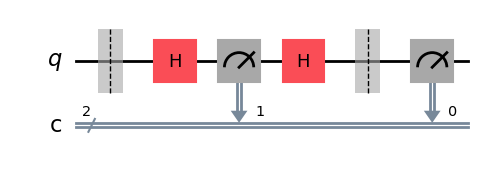

In [14]:
circuit.draw(output="mpl")

Let us just count the results for Alice and Bob only.

In [15]:
counts_wE = {} # counts with Eve present
out_wE = [(outA[i][0], outB[i][0], outA[i][1], outB[i][1]) for i in range(runs)]
for x in out_wE:
    counts_wE[x] = counts_wE.get(x, 0) + 1

We observe few more different outcomes in contrast to the ideal case.

In the cases of our interest, where $a=b$, we find that the keys are no longer the same. In roughly $1/4$ of the cases they observe the effect of Eve's interference.

In [16]:
eq_out_wE = {(0, 0): 0, (0, 1): 0, (1, 0): 0, (1, 1): 0}
for x in counts_wE:
    if x[0] == x[1]:
        eq_out_wE[x[2:]] += counts_wE[x]
print(eq_out_wE)

{(0, 0): 1840, (0, 1): 600, (1, 0): 670, (1, 1): 1888}


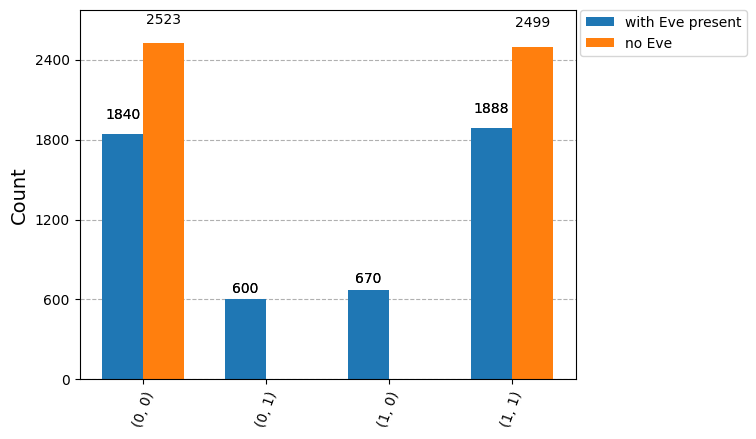

In [17]:
plot_histogram([eq_out_wE, eq_out], legend=["with Eve present", "no Eve"])

We indeed see similar probabilities to the expected ones: $P(0,0)=P(1,1)=3/8=0.375$ and $P(0,1)=P(1,0)=1/8=0.125$.

Let us formally continue in the process of key establishment, when Alice and Bob publicly, through an authenticated channel compare their choices of the bases. If Eve can perfectly eavesdrop on this channel, she can also try to reconstruct key on her side by selecting only the bits where Alice's and Bob's choices of basis were the same.

In [18]:
# Publicly shared information of ALice and Bob
publicA = [x[0] for x in outA]
publicB = [y[0] for y in outB]

# Locally stored keys obtained from public information
keyA = []
keyB = []
keyE = []

for i in range(runs):
    if publicA[i] == publicB[i]:
        keyA += [outA[i][1]]
        keyB += [outB[i][1]]
        keyE += [outE[i][1]]

We can now construct a correlator function which will tell us in how many % compared keys are the same.

In [19]:
def correlation(x, y):
    size = len(x)
    count = 0
    for j in range(size):
        if x[j] == y[j]:
            count += 1
    return count / size

Comparing keys of Alice and Bob we see that thay agree in only 75% of instances.

In [20]:
print("Alice's and Bob's keys agree in {:.1f}% bits".format(100*correlation(keyA, keyB)))

Alice's and Bob's keys agree in 74.6% bits


Comparing Alice's or Bob's keys with Eve's key we see similar correlation.

In [21]:
print("Alice's and Eve's keys agree in {:.1f}% bits".format(100*correlation(keyA, keyE)))
print("Bob's and Eve's keys agree in {:.1f}% bits".format(100*correlation(keyB, keyE)))

Alice's and Eve's keys agree in 75.5% bits
Bob's and Eve's keys agree in 74.0% bits


## Why is it so?

The possibilities of what is happening in cases when $a=b$ are displayed in the table below:
| **x** | **a = b** | **e** | **State sent by Alice** | **z (Eve's measured bit)** | **State Eve forwards to Bob** | **State after Bob changes it** | $P(y=\mathbf{0}|x,a,b)$ | $P(y=\mathbf{1}|x,a,b)$ |
|---|---|---|---|---|---|---|---|---|
| 0 | 0 | 0 | $|0\rangle$ | 0 | $|0\rangle$ | $|0\rangle$ | $1/8$ | $0$ |
| 0 | 0 | 1 | $|0\rangle$ | 0 (with probability $1/2$) | $|+\rangle$ | $|+\rangle$ | $1/32$ | $1/32$ |
| 0 | 0 | 1 | $|0\rangle$ | 1 (with probability $1/2$) | $|-\rangle$ | $|-\rangle$ | $1/32$ | $1/32$ |
| 0 | 1 | 0 | $|+\rangle$ | 0 (with probability $1/2$) | $|0\rangle$ | $|+\rangle$ | $1/32$ | $1/32$ |
| 0 | 1 | 0 | $|+\rangle$ | 1 (with probability $1/2$) | $|1\rangle$ | $|-\rangle$ | $1/32$ | $1/32$ |
| 0 | 1 | 1 | $|+\rangle$ | 0 | $|+\rangle$ | $|0\rangle$ | $1/8$ | $0$ |
| 1 | 0 | 0 | $|1\rangle$ | 1 | $|1\rangle$ | $|1\rangle$ | $0$ | $1/8$ |
| 1 | 0 | 1 | $|1\rangle$ | 0 (with probability $1/2$) | $|+\rangle$ | $|+\rangle$ | $1/32$ | $1/32$ |
| 1 | 0 | 1 | $|1\rangle$ | 1 (with probability $1/2$) | $|-\rangle$ | $|-\rangle$ | $1/32$ | $1/32$ |
| 1 | 1 | 0 | $|-\rangle$ | 0 (with probability $1/2$) | $|0\rangle$ | $|+\rangle$ | $1/32$ | $1/32$ |
| 1 | 1 | 0 | $|-\rangle$ | 1 (with probability $1/2$) | $|1\rangle$ | $|-\rangle$ | $1/32$ | $1/32$ |
| 1 | 1 | 1 | $|-\rangle$ | 1 | $|-\rangle$ | $|-\rangle$ | $0$ | $1/8$ |


We see that in half of the cases when $a=b$ Eve will guess a wrong basis and Alice and Bob's outcomes will be the same only half of the time, introducing errors in $1/4$ of total cases, which is detectable by Alice and Bob.